In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud

from nltk.corpus import stopwords

import re
from collections import defaultdict
from nltk.corpus import wordnet as wn

from nltk.stem import WordNetLemmatizer, PorterStemmer

from nltk import pos_tag

import gensim.downloader as api

from sklearn import model_selection

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report

import pickle

In [65]:
df = pd.read_csv('DB/sentence.csv')

In [66]:
df.head(10)

,Sentence,Symptom
0,I've been feeling a terrible itch all over my ...,Itching
1,"I've got this unbearable itching sensation, it...",Itching
2,"The itching is so bad, I can't stop scratching...",Itching
3,"This constant itching is really bothering me, ...",Itching
4,"Doctor, I've been experiencing intense itching...",Itching
5,"I've developed a red, bumpy rash on my arm, an...",skin rash
6,There's this rash on my chest that's been spre...,skin rash
7,I have a strange rash that appeared overnight...,skin rash
8,"This rash on my face is embarrassing, and I do...",skin rash
9,I'm concerned about this rash because it's cau...,skin rash


In [67]:
df.size

374

In [68]:
df.describe()

,Sentence,Symptom
count,187,187
unique,161,12
top,"I can't stop sneezing, it's been going on for ...",irrelevent
freq,26,70


In [69]:
type(df)

pandas.core.frame.DataFrame

In [70]:
#df = pd.DataFrame(df)

In [71]:
df['Sentence'] = [entry.lower() for entry in df['Sentence']]

In [72]:
df.head()

,Sentence,Symptom
0,i've been feeling a terrible itch all over my ...,Itching
1,"i've got this unbearable itching sensation, it...",Itching
2,"the itching is so bad, i can't stop scratching...",Itching
3,"this constant itching is really bothering me, ...",Itching
4,"doctor, i've been experiencing intense itching...",Itching


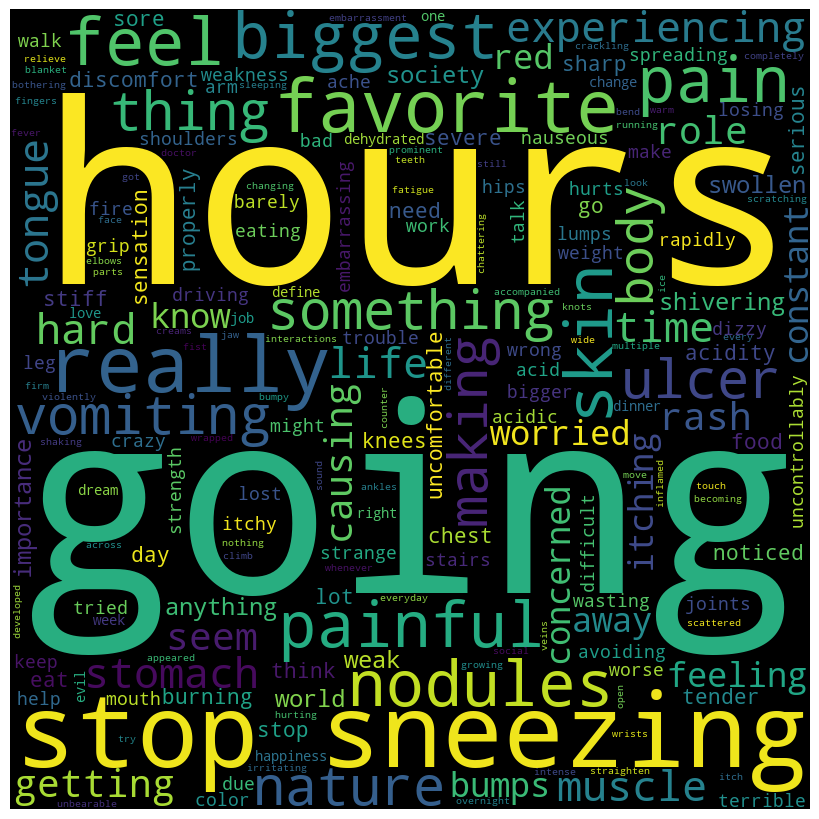

In [73]:
text = " ".join(review for review in df['Sentence'])
wordcloud = WordCloud(width=800, height=800, min_font_size=8).generate(text)

plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [74]:
custom_stopwords = set(stopwords.words('english')).union({'doctor', 'feel', 'feeling', 'experience', 'experiencing', 'sensation', 'really', 'get', 'got', 'just'})

In [75]:
def preprocess_sentence(sentence):

    sentence = re.sub(r'[^a-zA\s]', '', sentence)

    tokens = sentence.split()

    tag_map = defaultdict(lambda: wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV

    lematizer = WordNetLemmatizer()
    stemmer = PorterStemmer()

    final_word = []

    for word, tag in pos_tag(tokens):

        if word not in custom_stopwords and word.isalpha():

            word_lematized = lematizer.lemmatize(word, tag_map[tag[0]])
            word_stemmed = stemmer.stem(word_lematized)
            final_word.append(word_stemmed)

    return " ".join(final_word)
    

In [76]:
df['cleaned_text'] = df['Sentence'].apply(preprocess_sentence)

glove_vectors = api.load("glove-wiki-gigaword-100")

def get_word_embeddings(sentence):
    words = sentence.split()

    embeddings = [glove_vectors[word] for word in words if word in glove_vectors]

    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(100)

In [77]:
df['embeddings'] = df['cleaned_text'].apply(get_word_embeddings)

df = df[df['embeddings'].apply(lambda x:x.sum() != 0)]

In [78]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(df['embeddings'].tolist(), df['Symptom'], test_size=0.2, random_state=0)

encoder = LabelEncoder()
train_y = encoder.fit_transform(train_y)
test_y = encoder.transform(test_y)

scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

In [79]:
# fgind the best hyperparameters for the SVM model by tring out different combination of 'c' and 'kernel'ArithmeticError

param_gris = {'C' : [0.1, 1, 10, 10, 100], 'kernel' : ['linear', 'rbf']}
grid = GridSearchCV(SVC(), param_gris, refit=True, verbose=2)
grid.fit(train_x, train_y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.0s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.0s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.0s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.0s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.0s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.0s
[CV] END .................................C=1, kernel=linear; total time=   0.0s
[CV] END .................................C=1, k

c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 10, 100],
                         'kernel': ['linear', 'rbf']},
             verbose=2)

In [80]:
# get the best combination of hyperparameters that resulted in the highest performance on the training data.
# Best estimator
print(f"Best parameters found: {grid.best_params_}")
classifier = grid.best_estimator_

Best parameters found: {'C': 10, 'kernel': 'rbf'}


In [81]:
# Making predictions
predictions = classifier.predict(test_x)

In [82]:
predictions

array([ 0,  3,  4,  4,  4,  2,  7, 11,  4,  7,  7,  6,  4,  5, 11,  6,  3,
       10,  4,  5,  7,  4,  5,  7,  4,  4,  4,  7,  4,  3,  0,  4,  4,  4,
        3,  3,  4,  4])

In [83]:
# Evaluate the model
print("Accuracy Score: ", accuracy_score(test_y, predictions))
print("Classification Report: \n", classification_report(test_y, predictions, target_names=encoder.classes_))

Accuracy Score:  0.6578947368421053
Classification Report: 
                       precision    recall  f1-score   support

             Itching       0.50      1.00      0.67         1
           Shivering       0.00      0.00      0.00         4
             acidity       1.00      1.00      1.00         1
 continuous sneezing       0.60      1.00      0.75         3
          irrelevent       0.88      1.00      0.93        14
          joint pain       0.33      0.33      0.33         3
      muscle wasting       0.50      1.00      0.67         1
nodal skin eruptions       0.17      1.00      0.29         1
           skin rash       0.00      0.00      0.00         2
        stomach pain       0.00      0.00      0.00         1
    ulcers on tongue       1.00      0.50      0.67         2
            vomiting       1.00      0.40      0.57         5

            accuracy                           0.66        38
           macro avg       0.50      0.60      0.49        38
       

c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [84]:
with open('Model/svm_model.pkl', 'wb') as file:
    pickle.dump(classifier, file)

with open('Model/label_encoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)

with open('Model/scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [85]:
# Load the trained model from the pickle file
with open('Model/svm_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Load the Label Encoder (if saved)
with open('Model/label_encoder.pkl', 'rb') as file:
    loaded_encoder = pickle.load(file)

# Load the Scaler (if saved)
with open('Model/scaler.pkl', 'rb') as file:
    loaded_scaler = pickle.load(file)

In [89]:
def predict_symptom(sentence):
    preprocesses_sentence = preprocess_sentence(sentence)
    embeddings = get_word_embeddings(preprocesses_sentence)
    embeddings = scaler.transform([embeddings])
    prediction = classifier.predict(embeddings)
    predicted_label = loaded_encoder.inverse_transform(prediction)
    return predicted_label[0]

In [100]:
sample_sentences = ["I'm concerned about this rash because it's causing me discomfort", "no","I have these strange knots on my skin that are causing me a lot of pain.","I'm experiencing terrible stomach pain, and I don't know what's wrong.","I've been experiencing acid reflux, and it's really uncomfortable.", "What", "stomach pain", "vomit"]
#nodal skin eruptions
#stomach pain
#acidity

In [101]:
for i in sample_sentences:
    print(predict_symptom(i))

skin rash
irrelevent
nodal skin eruptions
stomach pain
irrelevent
irrelevent
ulcers on tongue
irrelevent
